My empty project: 

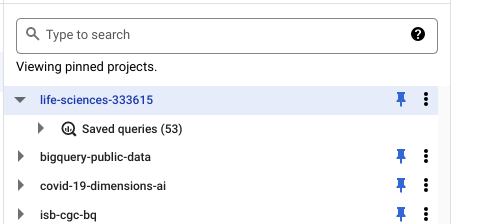

Go install the cheminformatics packge from here [Cheminformatics in BQ](https://github.com/vjb-collab/cheminformatics-bq)

Then you have this

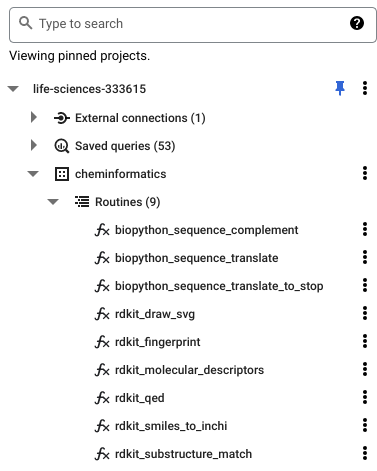

create some test data set to start with. We use the bin_id to partition the data set

In [48]:
%%timeit -n 1 -r 1
%%bigquery

BEGIN

CREATE SCHEMA sample_data;

create or replace table `sample_data.smiles` as
(
SELECT product_smiles as smiles,
fhoffa.x.random_int(0,3999) as bin_id 
from `nih-nci-cbiit-chem-prod.savi.plus` 
where rand() < 0.01
);

END

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1088.58query/s]

14.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


the sample data has 10 million compounds in it

now partition it (why do I need to do this?)

In [51]:
%%timeit -n 1 -r 1
%%bigquery

CREATE TABLE sample_data.smiles_bin_parted (smiles STRING, bin_id INT64)
PARTITION BY
  RANGE_BUCKET(bin_id, GENERATE_ARRAY(0, 3999, 1))
as
(select * from sample_data.smiles)

Query complete after 0.00s: 100%|██████████| 2/2 [00:00<00:00, 1239.82query/s]                        

37.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


create an exports dataset to store intermediate transform data

In [50]:
%%bigquery

CREATE SCHEMA exports;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 988.06query/s] 


""


In [54]:
%%timeit -n 1 -r 2

%%bigquery 

create or replace table `exports.smiles_fp_mol_descriptors_json` as
(
SELECT smiles,
`cheminformatics.rdkit_fingerprint`(smiles) as fingerprint_json,
`cheminformatics.rdkit_molecular_descriptors`(smiles) as molecular_descriptors_json,
from `sample_data.smiles_bin_parted` 
)

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1855.34query/s]                        

3min 19s ± 10.9 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


extract data from json and cluster table

In [56]:
%%timeit -n 1 -r 1

%%bigquery

create or replace table `exports.smiles_fp_mol_descriptors_clustered`
cluster by num_carbon, num_nitrogen, num_oxygen, num_fluorine
as
(
SELECT smiles,
FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_pattern_long_as_binary_hex'))  as fp_pattern_as_binary,
FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_morgan_as_binary_hex'))  as fp_morgan_as_binary,
CAST(JSON_VALUE(fingerprint_json, "$.num_carbon") as INT64) as num_carbon,
CAST(JSON_VALUE(fingerprint_json, "$.num_oxygen") as INT64) as num_oxygen,
CAST(JSON_VALUE(fingerprint_json, "$.num_nitrogen") as INT64) as num_nitrogen,
CAST(JSON_VALUE(fingerprint_json, "$.num_fluorine") as INT64) as num_fluorine,
CAST(JSON_VALUE(fingerprint_json, "$.num_sulfur") as INT64) as num_sulfur,
CAST(JSON_VALUE(molecular_descriptors_json, "$.ExactMolWt") as FLOAT64 ) as exact_mol_wt,
CAST(JSON_VALUE(molecular_descriptors_json, "$.FractionCSP3") as FLOAT64 ) as fraction_csp3,
CAST(JSON_VALUE(molecular_descriptors_json, "$.BalabanJ") as FLOAT64 ) as balabanj,
CAST(JSON_VALUE(molecular_descriptors_json, "$.BertzCT") as FLOAT64 ) as bertzct,
CAST(JSON_VALUE(molecular_descriptors_json, "$.HallKierAlpha") as FLOAT64 ) as hallkieralpha,
CAST(JSON_VALUE(molecular_descriptors_json, "$.HeavyAtomMolWt") as FLOAT64 ) as heavy_atom_mol_wt,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MaxAbsPartialCharge") as FLOAT64 ) as max_abs_partial_charge,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MaxPartialCharge") as FLOAT64 ) as max_partial_charge,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MolLogP") as FLOAT64 ) as mol_logp,
CAST(JSON_VALUE(molecular_descriptors_json, "$.MolMR") as FLOAT64 ) as mol_mr,
CAST(JSON_VALUE(molecular_descriptors_json, "$.HeavyAtomCount") as INT64 ) as heavy_atom_count,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAliphaticRings") as INT64 ) as num_aliphatic_rings,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NHOHCount") as INT64 ) as nhoh_count,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NOCount") as INT64 ) as no_count,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAliphaticCarbocycles") as INT64 ) as num_alpiphatic_carbocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAliphaticHeterocycles") as INT64 ) as num_aliphatic_heterocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAromaticCarbocycles") as INT64 ) as num_aromatic_carbocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAromaticHeterocycles") as INT64 ) as num_aromatic_heterocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumAromaticRings") as INT64 ) as num_aromatic_rings,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumHAcceptors") as INT64 ) as num_h_acceptors,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumHDonors") as INT64 ) as num_h_donors,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumHeteroatoms") as INT64 ) as num_hetero_atoms,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumRadicalElectrons") as INT64 ) as num_radical_electrons,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumRotatableBonds") as INT64 ) as num_rotatable_bonds,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumSaturatedCarbocycles") as INT64 ) as num_saturated_carbocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumSaturatedHeterocycles") as INT64 ) as num_saturated_heterocycles,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumSaturatedRings") as INT64 ) as num_saturated_rings,
CAST(JSON_VALUE(molecular_descriptors_json, "$.NumValenceElectrons") as INT64 ) as num_valence_electrons
from `exports.smiles_fp_mol_descriptors_json` where fingerprint_json != "" and molecular_descriptors_json != ""
)

Query complete after 0.00s: 100%|██████████| 5/5 [00:00<00:00, 2780.26query/s]                        

42.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Create substructure search based on the above compound registry

In [59]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE PROCEDURE `cheminformatics.substructure_search`(fragment_smiles STRING)
BEGIN

declare json_return STRING;
declare fragment_num_carbon, fragment_num_nitrogen, fragment_num_oxygen, fragment_num_fluorine, bit_count_fragment INT64;
declare fragment_pattern_fp BYTES;
declare fragment_bit_count INT64;

set json_return=`cheminformatics.rdkit_fingerprint`(fragment_smiles);
set fragment_pattern_fp = FROM_HEX(JSON_VALUE(json_return, "$.fp_pattern_long_as_binary_hex"));
set fragment_num_carbon = CAST(JSON_VALUE(json_return, "$.num_carbon") as INT64);
set fragment_num_oxygen = CAST(JSON_VALUE(json_return, "$.num_oxygen") as INT64);
set fragment_num_nitrogen = CAST(JSON_VALUE(json_return, "$.num_nitrogen") as INT64);
set fragment_num_fluorine = CAST(JSON_VALUE(json_return, "$.num_fluorine") as INT64);
set fragment_bit_count = bit_count(fragment_pattern_fp);

select smiles from `exports.smiles_fp_mol_descriptors_clustered`
where
num_carbon >= fragment_num_carbon and
num_nitrogen >= fragment_num_nitrogen and
num_oxygen >= fragment_num_oxygen and
num_fluorine >= fragment_num_fluorine and
bit_count(fragment_pattern_fp & fp_pattern_as_binary) = fragment_bit_count
and
`cheminformatics.rdkit_substructure_match`(fragment_smiles, smiles);
END;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1048.58query/s]

1.77 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [117]:
%%timeit -n 1 -r 1
%%bigquery df

CALL `cheminformatics.substructure_search`("C(CCN)CC");

Downloading: 100%|██████████| 3144511/3144511 [00:02<00:00, 1073339.52rows/s]


29.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [118]:
df

,smiles
0,N(C1=CC=C(C=C1)[S](F)(F)(F)(F)F)C(=O)C2CCC3=C2...
1,N(C1=C(C=CC=C1)F)C(=O)[C@]2(F)C[C@H]2C3=CC=CC=C3
2,N(C1=C(C(=CC=C1)Br)F)C(=O)CCCC2=CC(=C(C=C2)F)F
3,N(C1=C(C(=C(C(=C1F)F)Cl)F)F)C(=O)[C@@H]2C[C@H]...
4,C2(=C1C=CC=CC1=CC=C2)NC3=CC(=O)CCC3
...,...
3144506,O(C(C1CCC(=O)NC1)C(F)(F)F)CCCC(N(CCCCC)C2=C(N)...
3144507,N([S](=O)(=O)N1CCC(F)(F)CC1)[S](C2=NN=C([N]2CC...
3144508,CC1=C(C=CC=C1C(F)(F)F)[S](=O)(=O)NC(C3CCN(C2=C...
3144509,COC(=O)C1=CC(=CC(=C1)C(F)(F)F)[S](=O)(=O)N[S](...


install morgan similarity with a radius (for filtering) and a tolerance

In [88]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE PROCEDURE `cheminformatics.morgan_similarity_radius`(smiles STRING, atom_radius INT64, tolerance FLOAT64)
BEGIN
declare json_return STRING;
declare morgan_fp BYTES;
declare in_num_carbon, in_num_nitrogen, in_num_oxygen, in_num_fluorine INT64;
set json_return=`cheminformatics.rdkit_fingerprint`(smiles);
set morgan_fp = FROM_HEX(JSON_VALUE(json_return, "$.fp_morgan_as_binary_hex"));
set in_num_carbon = CAST(JSON_VALUE(json_return, "$.num_carbon") as INT64);
set in_num_oxygen = CAST(JSON_VALUE(json_return, "$.num_oxygen") as INT64);
set in_num_nitrogen = CAST(JSON_VALUE(json_return, "$.num_nitrogen") as INT64);
set in_num_fluorine = CAST(JSON_VALUE(json_return, "$.num_fluorine") as INT64);
 select smiles from `exports.smiles_fp_mol_descriptors_clustered`
where
num_carbon in UNNEST(GENERATE_ARRAY(in_num_carbon-atom_radius, in_num_carbon+atom_radius, 1))
and
num_nitrogen in UNNEST(GENERATE_ARRAY(in_num_nitrogen-atom_radius, in_num_nitrogen+atom_radius, 1))
and
num_oxygen in UNNEST(GENERATE_ARRAY(in_num_oxygen-atom_radius, in_num_oxygen+atom_radius, 1))
and
num_fluorine in UNNEST(GENERATE_ARRAY(in_num_fluorine-atom_radius, in_num_fluorine+atom_radius, 1))
and
bit_count(morgan_fp & fp_morgan_as_binary) / bit_count(morgan_fp || fp_morgan_as_binary) > tolerance;
END;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 331.96query/s] 

1.44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [114]:
%%timeit -n 1 -r 1
%%bigquery df

CALL `cheminformatics.morgan_similarity_radius`("C[C@@H](CC(=C)C)C(=O)OCC1[C@@H]2COC[C@H]12", 4, 0.35);

Downloading: 100%|██████████| 10/10 [00:02<00:00,  4.95rows/s]

4.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [115]:
df

,smiles
0,O(CC1[C@@H]2COC[C@H]12)C(CC(OC)C)=O
1,CC(CCCN)C(=O)OCC1[C@@H]2COC[C@H]12
2,CC[C@H](N)C(=O)OCC1[C@@H]2COC[C@H]12
3,O(CC1[C@@H]2COC[C@H]12)C(C(C)[N]3C=CC=C3)=O
4,CC(CC(C)(C)N)C(=O)OCC1[C@@H]2COC[C@H]12
5,CC(C(N)C(=O)OCC1[C@@H]2COC[C@H]12)C3CC3
6,NC(C1CCCC1)C(=O)OCC2[C@@H]3COC[C@H]23
7,CCOC(=O)C(N)C(=O)OCC1[C@@H]2COC[C@H]12
8,CC(C)C(N)C(=O)OCC1[C@@H]2COC[C@H]12
9,CCN(CC)C(C(C)C)C(=O)OCC1[C@@H]2COC[C@H]12


in the project, you now have the two additional routines for substructure search and similarity search

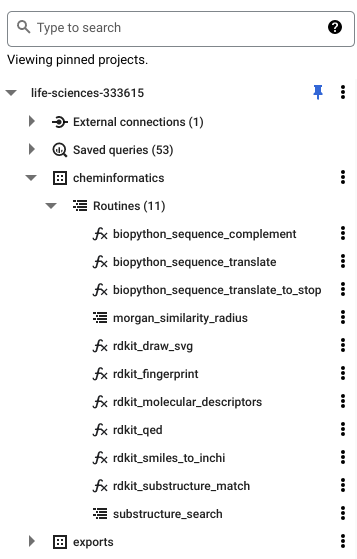

for bio example

In [129]:
%%timeit -n 1 -r 1
%%bigquery df 

SELECT 
`cheminformatics.biopython_sequence_translate`("gtatctagaagaaagaacgatgcggctcccacgtgcaaactctctaagaattacactgtttgtccatgagcgcgctacaatgatatcggtccctcgcctccacaaccgggacttgctttatgcgggctccagctgattgagacatagtgagcctcacaactgcgtcgccttcacgccgcagctggagcggtaaaagtttaactattactacagtcgggtcatgactttgtccaggactacgcctatgggtcc") as amino_acid_literal,
`cheminformatics.biopython_sequence_translate_to_stop`("gtatctagaagaaagaacgatgcggctcccacgtgcaaactctctaagaattacactgtttgtccatgagcgcgctacaatgatatcggtccctcgcctccacaaccgggacttgctttatgcgggctccagctgattgagacatagtgagcctcacaactgcgtcgccttcacgccgcagctggagcggtaaaagtttaactattactacagtcgggtcatgactttgtccaggactacgcctatgggtcc") as amino_acid_translated;

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.93s/rows]

2.69 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [130]:
df

,amino_acid_literal,amino_acid_translated
0,VSRRKNDAAPTCKLSKNYTVCP*ARYNDIGPSPPQPGLALCGLQLI...,VSRRKNDAAPTCKLSKNYTVCP
